# 上市公司基本情况

- 使用tushare免费的基础信息数据集。(很遗憾,就在2023年5月底这几天,不免费了)
- 2024年7月底，使用akshare的工具从em和cninfo获取数据。
- 数据获取工具放在mytools中。在本文件夹中只拷贝了下载好的数据。
    - em_data.csv
    - cninfo_data.csv

## 数据集的基本情况

### em基本情况

In [1]:
import pandas as pd
import akshare as ak
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import numpy as np
from IPython.display import HTML

In [2]:
# 解决matplotlib的中文问题
# bash中使用fc-list 找到family name
# plt.rcdefaults() # 样式调乱了，需要用它重置一下。
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)
# 设置全局字体为
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('ggplot')

In [3]:
def showProfile(df) :
    col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
    col_profile.columns = ['列名', '类型', '缺失比%','样例']
    
    return (col_profile)

In [4]:
def plot_barh(df):
    height = len(df)*25/72+0.5
    ax = df.plot.barh(figsize=(10, height), width=0.8, legend=False, zorder=3)
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.xaxis.tick_top()
    ax.xaxis.grid(True, color='#EEEEEE', zorder=0)
    ax.tick_params(left=False, bottom=False, top=False, right=False)
    ax.set_title(df.columns[0], fontsize=16, pad=20)
    
    plt.show(ax)



In [5]:
def plot_line(df, title=''):
    ax = df.plot.line(figsize=(10, 5), title=title)
    ax.tick_params(left=False, bottom=False)
    ax.yaxis.grid(True, color = '#EEEEEE')
    return plt.show(ax)

In [6]:
def s_to_card(ser):
    sty = '''
    <style>
      .card_group {
        display: flex;
        flex-wrap: wrap;
        justify-content: center;
        text-align: center;
      }

      .card {
        display: flex;
        flex-direction: column;
        justify-content: center;
        align-items: center;
        background: #fff;
        border-radius: 10px;
        display: inline-block;
        height: 260px;
        margin: 1rem;
        width: 260px;
        box-shadow: 0 3px 6px rgba(0, 0, 0, 0.12), 0 3px 6px rgba(0, 0, 0, 0.24);
      }

      .card_title {
        border-bottom: 5px;
        border-bottom-style: dotted;
        border-bottom-color: grey;
        margin: 5px;
        padding: 5px;
        font-size: 2em;
      }
      .card_content {
        font-size: 4em;
        margin: 5px;
        align-self: center;
        height: 200px;

        display: flex;
        align-items: center;
        justify-content: center;
        justify-items: center;
      }
    </style>
    '''
    card_html=''
    for a, b in ser.items():
        card_title=a
        card_content=b
        card=f'''
        <div class="card">
            <div class="card_title">{card_title}</div>
            <div class="card_content">
            <span>{card_content}</span>
            </div>
        </div>
        '''
        card_html = card_html+card

    card_group = f'''
    {sty}
    <div class="card_group">
        {card_html}
    </div>
    '''

    return HTML(card_group)

In [7]:
class BasicData:
    def __init__(self):
        self.em_df = pd.read_csv('em_data.csv', dtype={'symbol':'str'})
        self.em_df = self.em_df.pivot(index='symbol', columns='item', values='value')
        self.em_df.replace('-', np.nan, inplace=True)

        self.info_df = pd.read_csv('cninfo_data.csv', parse_dates=['上市日期', '成立日期'], dtype={'symbol':'str'})
        self.info_df.replace(np.nan, '', inplace=True)
        self.info_df['cname'] = self.info_df['A股简称'] + self.info_df['B股简称'] + self.info_df['H股简称']
        self.info_df['cname'] = self.info_df['cname'].str[:4] # 保留一个中文名称

    def showProfile(self, df) :
        col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
        col_profile.columns = ['列名', '类型', '缺失比%','样例']
        return (col_profile)
    
    def dlisted(self):
        dl = len(self.em_df[self.em_df['总股本'].isna()])
        l =  len(self.em_df) - dl
        res = pd.Series([l, dl], index=['上市', '退市'])
        return s_to_card(res)
    
    def new_listed(self):
        byy=(self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[:4]).count().to_frame(name='年度新增上市数量'))
        bym=(self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[4:6]).count().to_frame(name='月份新增上市数量'))
        byd=(self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[6:]).count().to_frame(name='按日新增上市数量'))
        topm = (self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[:6]).count().sort_values(ascending=1)).to_frame('上市数量最多的月份前十').tail(10)
        topd = (self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[:8]).count().sort_values(ascending=1)).to_frame('上市数量最多的日期前十').tail(10)
        return (byy, bym, topm, byd,  topd)
    
    def cninfo(self):
        by_market = self.info_df.groupby('所属市场')['symbol'].count().sort_values().to_frame('分市场上市公司数量')
        by_year = self.info_df.copy()
        by_year['lyear'] = by_year['上市日期'].dt.year
        bymy = by_year.pivot_table(index='lyear', columns='所属市场', values='symbol', aggfunc='count')
        top_indu = by_year['所属行业'].groupby(by_year['所属行业']).count().sort_values(ascending=1).tail(40).to_frame(name='拥挤行业')
        tail_indu = by_year['所属行业'].groupby(by_year['所属行业']).count().sort_values(ascending=0).tail(40).to_frame(name='冷清行业')
        return (by_market, [bymy, '各板块上市公司数量变化'], top_indu, tail_indu)

bd = BasicData()

In [8]:
bd.showProfile(bd.em_df)

,列名,类型,缺失比%,样例
0,上市时间,object,0.088936,20140129
1,总市值,object,4.500178,2076159999.9999998
2,总股本,object,4.446816,256000000.0
3,流通市值,object,4.517965,1703229435.6
4,流通股,object,4.517965,210015960.0
5,股票代码,object,0.000000,002725
6,股票简称,object,0.000000,跃岭股份
7,行业,object,4.589114,汽车零部件


这个数据是更新至下载当天的情况：

- 股票代码中包括了已经退市的股票，特征是总股本为‘-’。
- 包括待上市的股票，特征旧总市值为’-‘。
- 总市值是下载当天的数据，可以用来做一些基本分析。

### cninfo基本情况

In [9]:
bd.showProfile(bd.info_df)

,列名,类型,缺失比%,样例
0,公司名称,object,0.000000,浙江亨通控股股份有限公司
1,英文名称,object,0.000000,"Zhejiang Hengtong Holding Co., Ltd."
2,曾用简称,object,0.000000,升华拜克>> 瀚叶股份>> *ST瀚叶>> ST瀚叶>> 瀚叶股份
3,A股代码,object,0.000000,600226.0
4,A股简称,object,0.000000,亨通股份
5,B股代码,object,0.000000,
6,B股简称,object,0.000000,
7,H股代码,object,0.000000,
8,H股简称,object,0.000000,
9,入选指数,object,0.000000,"国证2000,国证Ａ指"


cninfo可以分析的点
- 分市场的上市公司数量。
- 成立时期到上市日期的时间跨度。
- 分行业上市公司数量。
- 主营业务和经营范围包含某个关键词的公司数量。

## 上市和退市

- 至数据更新时,A股三市现存上市公司5372家。
- 退市250家，但由于没有退市日期，无法分年度分析。

In [10]:
bd.dlisted()

## 每年新增上市公司
- 目前没有退市的上市公司,分板块,分市场,分行业情况.


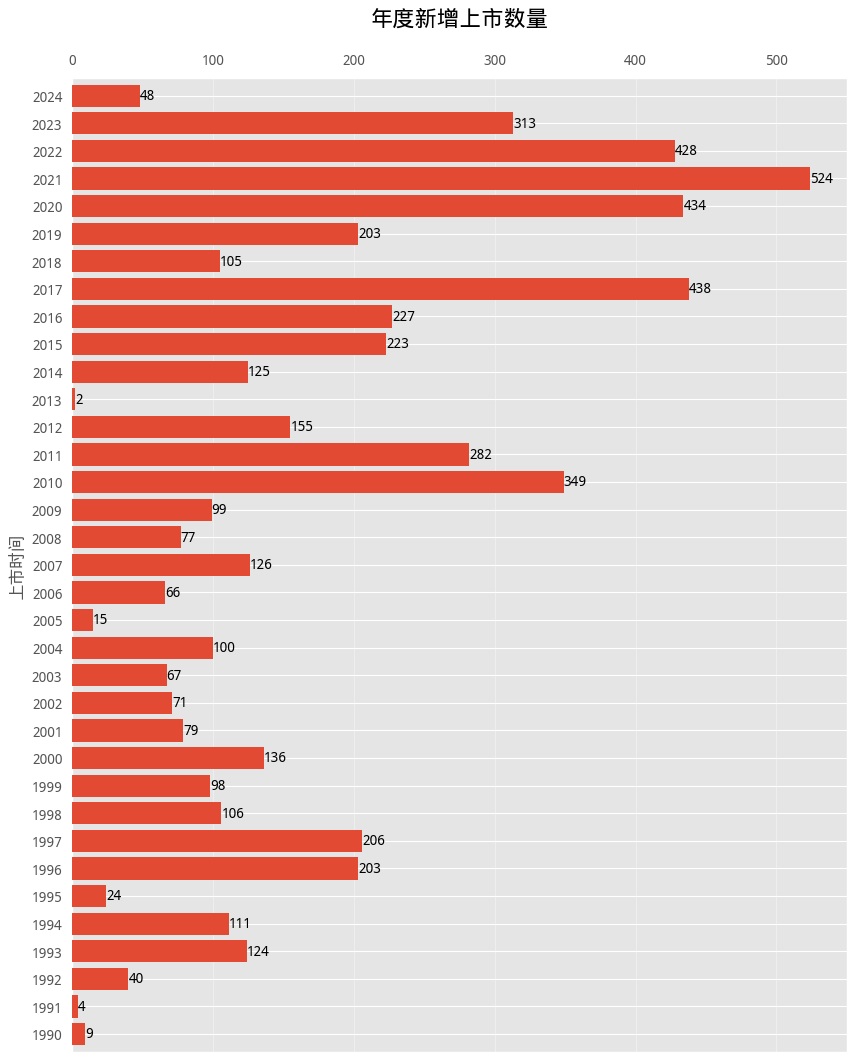

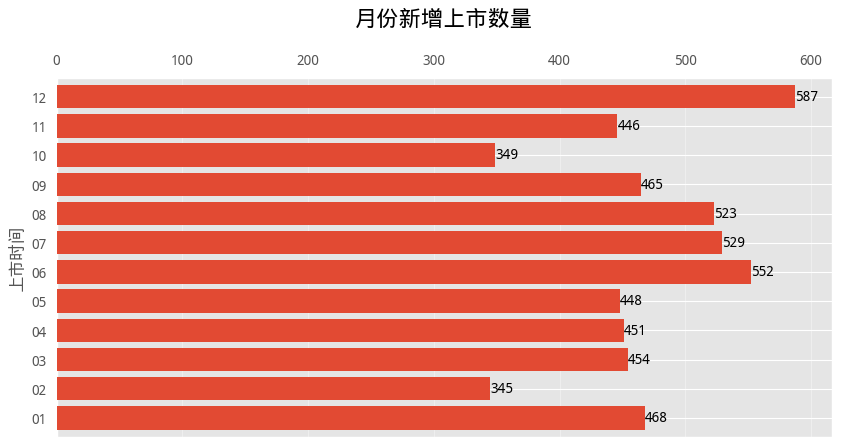

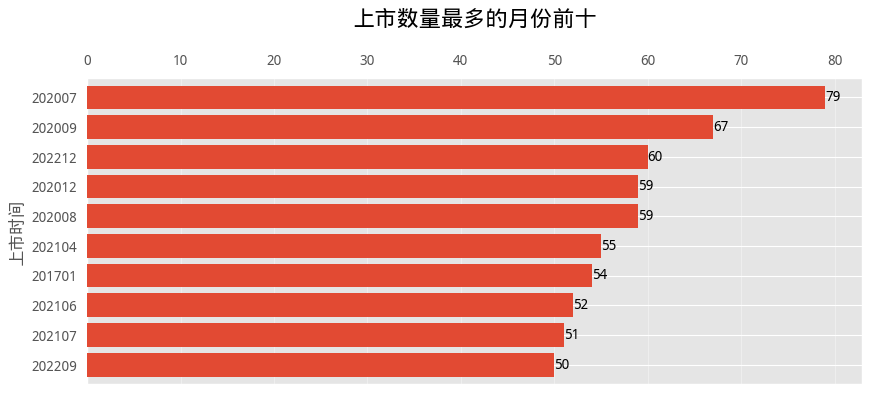

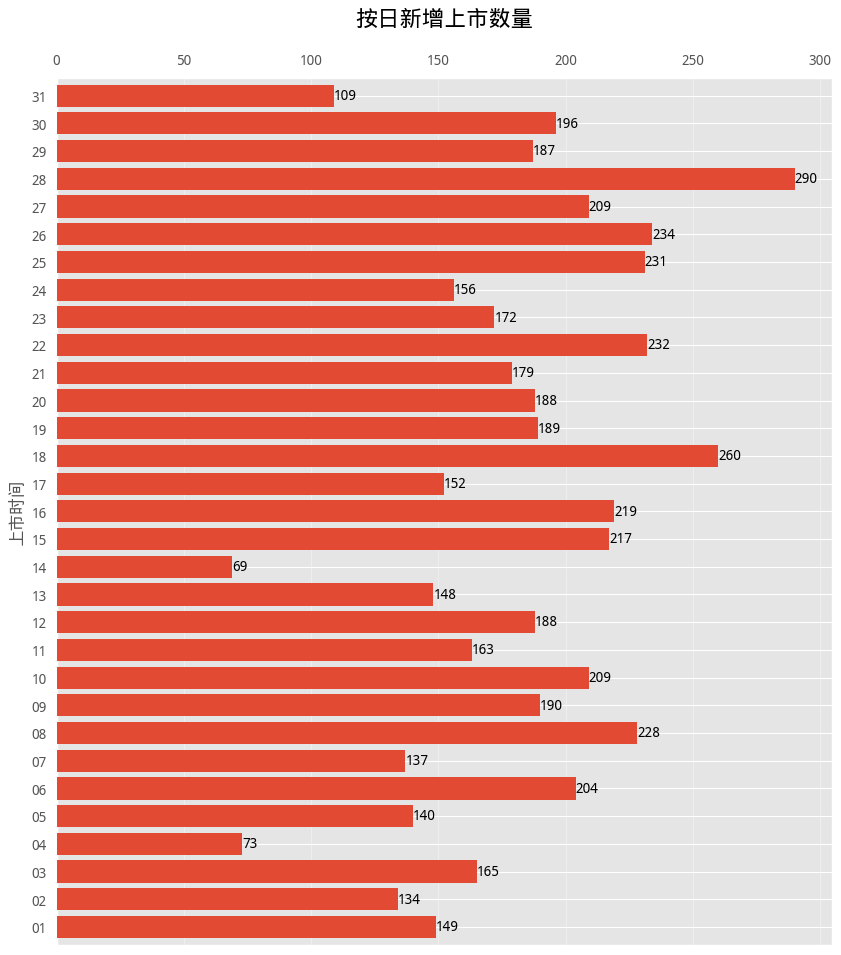

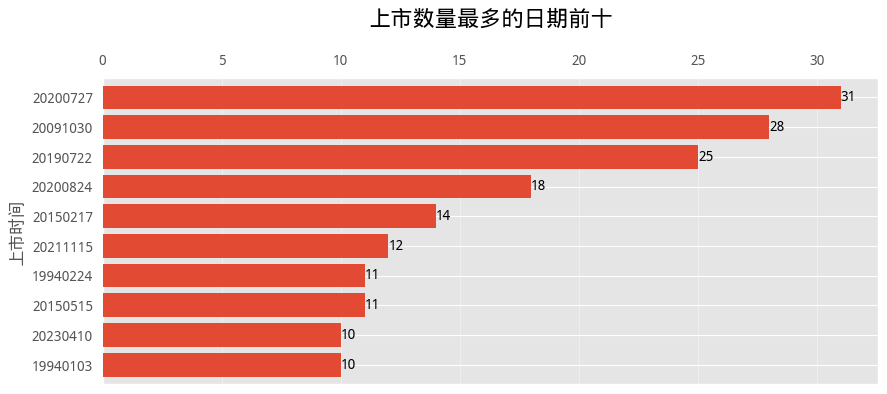

In [11]:
for g in bd.new_listed():
    plot_barh(g)

- 疫情三年各疫情前的2019年，上市公司数量增长大跃进。
- 2024年，时间过半之后，仍然增长只有几十家，预计会是个小年。
- 喜欢在12月、1月和6月上市。
- 28号、18号和8号是最受欢迎的上市日期。
- 从具体单日新增长上市公司数量来看，从2009年开始，每十年会有疯狂的时候。

## 交易所和板块
- 三个交易所,四个板块
- 从交易所上市数量来看,深交所规模最大,北交所成立较晚规模最小
- 主板规模最大

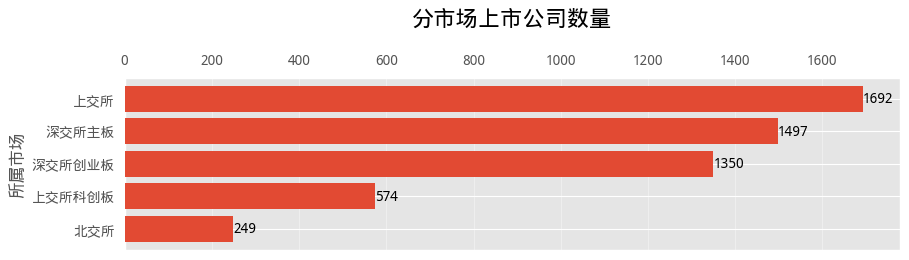

In [12]:
plot_barh(bd.cninfo()[0])

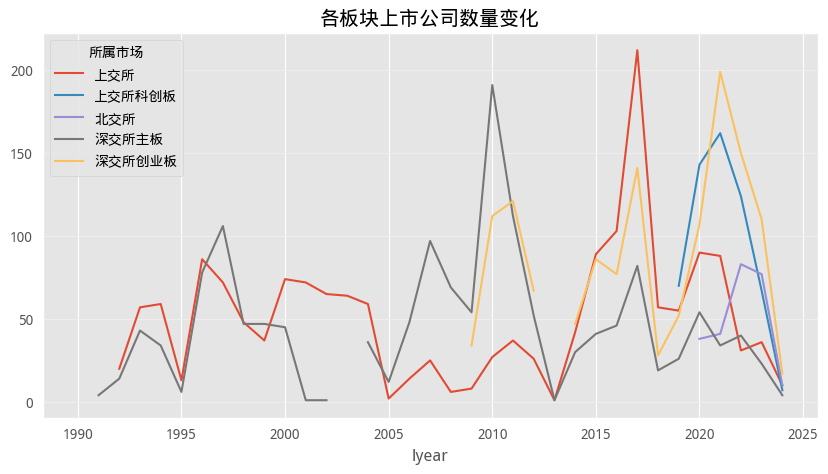

In [13]:
plot_line(*bd.cninfo()[1])

- 北交所没有区分板块
- 上交所交易主板和科创板
- 深交所交易主板和创业板

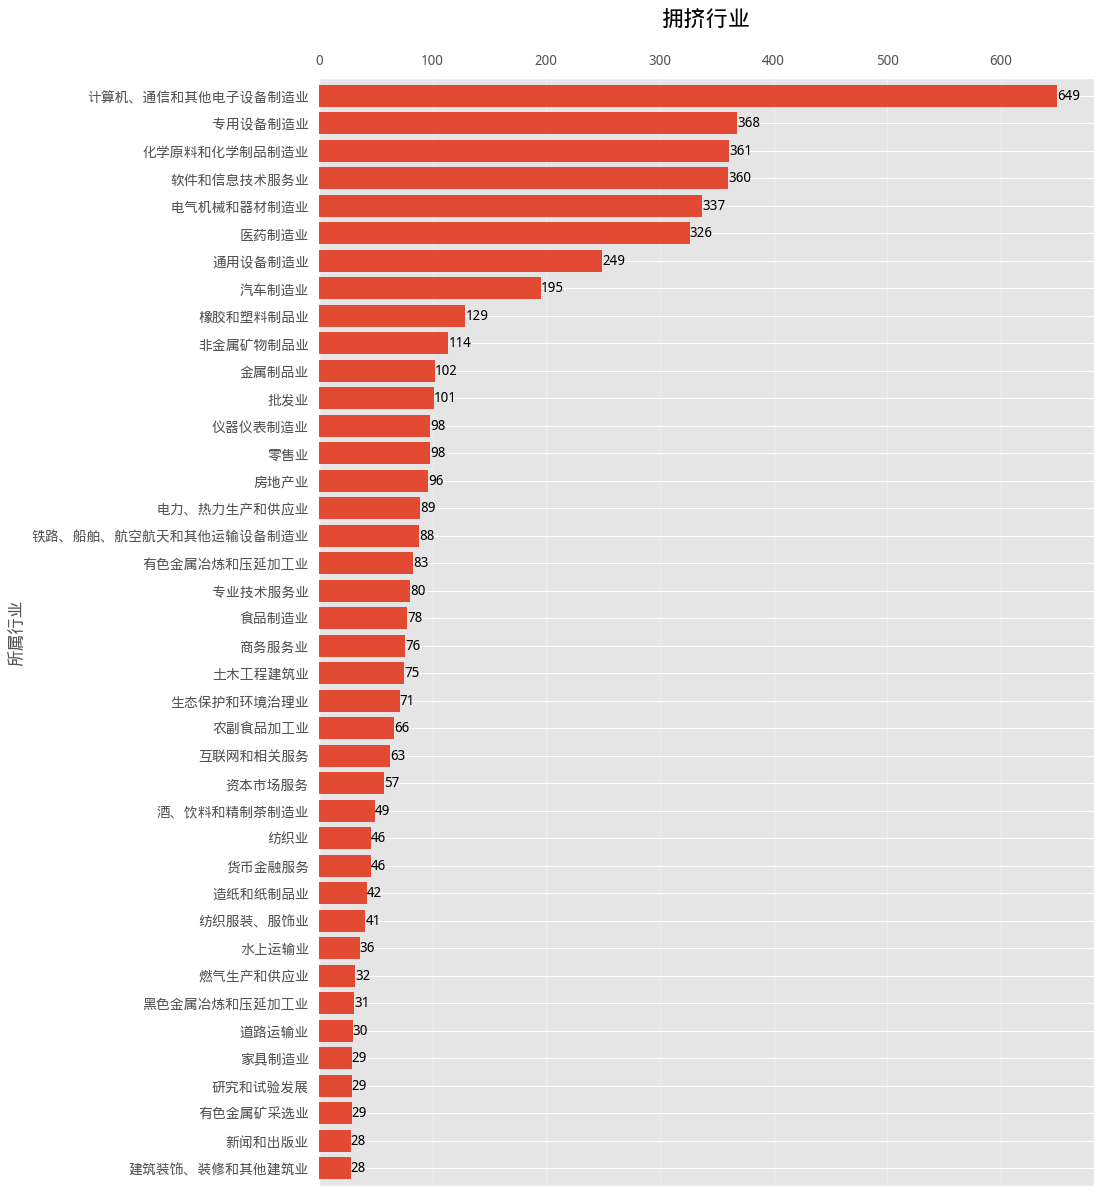

In [14]:
plot_barh(bd.cninfo()[2])

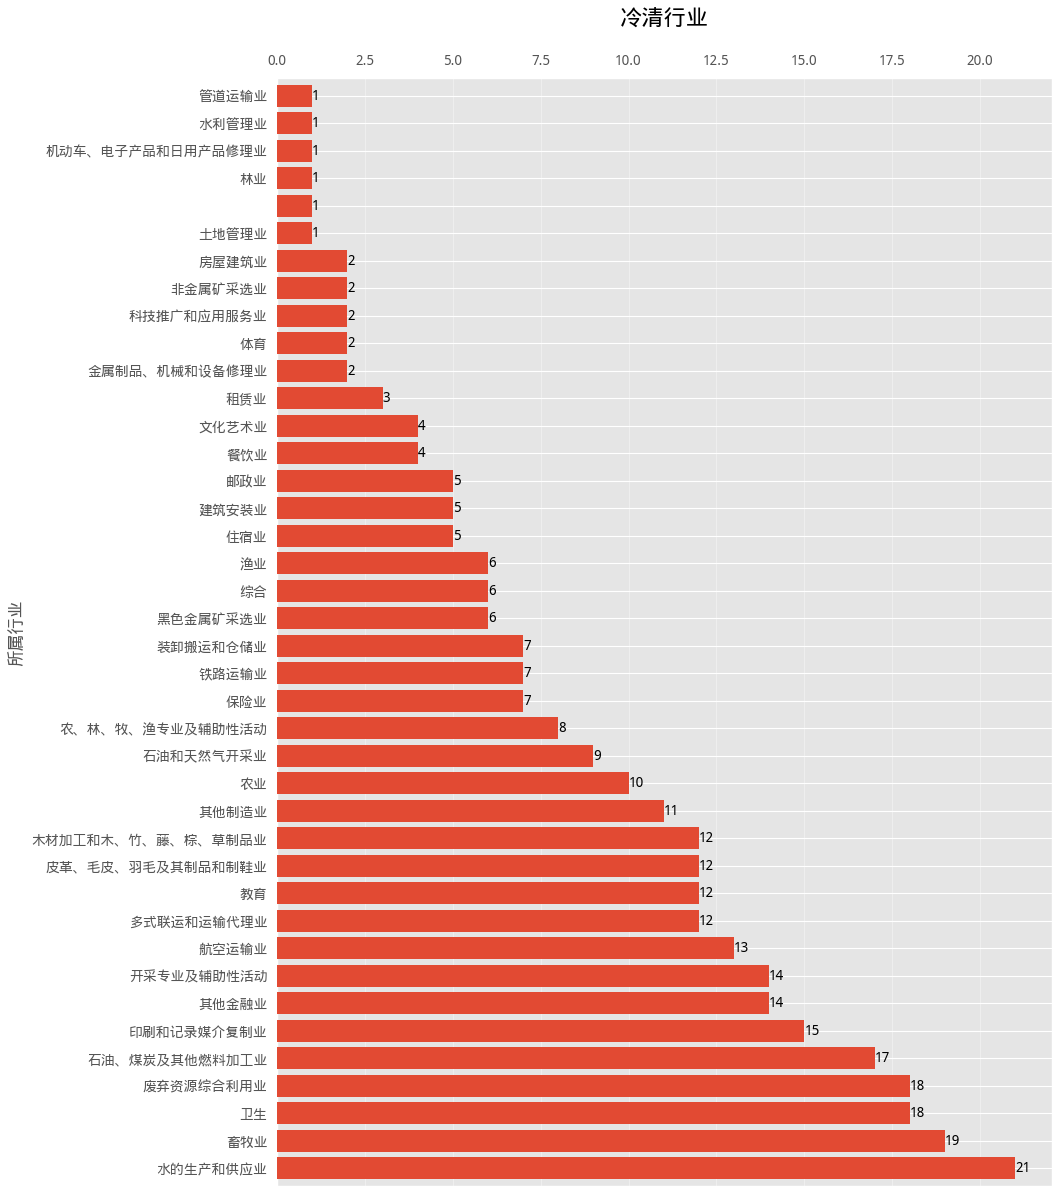

In [15]:
plot_barh(bd.cninfo()[3])

In [16]:
import nbformat as nbf
from pathlib import Path
def remove_input():
    fn = Path('01_listed.ipynb')
    nb = nbf.read(fn, nbf.NO_CONVERT)
    for cell in nb.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        if not 'remove_input' in cell_tags:
            cell_tags.append('remove_input')
            cell['metadata']['tags'] = cell_tags
    nbf.write(nb, fn)
remove_input()